In [1]:
# prompt: เชื่อมไดฟ

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# เชื่อมต่อกับ GPU T4 ใน Google Colab
!nvidia-smi  # ตรวจสอบว่าเชื่อมต่อกับ GPU แล้ว

/bin/bash: line 1: nvidia-smi: command not found


In [4]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [15]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Load a pre-trained YOLO model (you can choose n, s, m, l, or x versions)
model = YOLO("yolo11n.pt")

100%|██████████| 5.35M/5.35M [00:00<00:00, 64.6MB/s]


In [ ]:
# -*- coding: utf-8 -*-
"""YOLO Training with Auto-Save to Drive (Fixed Version).ipynb

Automatically generated by Colaboratory.
"""

# ขั้นตอนที่ 1: ติดตั้ง dependencies
!pip install ultralytics pyyaml

# ขั้นตอนที่ 2: เชื่อมต่อ Google Drive
from google.colab import drive
drive.mount('/content/drive')

# ขั้นตอนที่ 3: ตรวจสอบ GPU
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# ขั้นตอนที่ 4: ตั้งค่า paths
import os
from datetime import datetime

# ตั้งค่า path ข้อมูล
DATA_YAML_PATH = "/content/drive/MyDrive/model/yolo400dataset/data.yaml"

# สร้าง folder สำหรับบันทึกโมเดล
MODEL_SAVE_DIR = "/content/drive/MyDrive/model/yolo400dataset/model"
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

# สร้างชื่อโฟลเดอร์ตามเวลา
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
RUN_NAME = f"human_box_detection_{current_time}"
FULL_RUN_PATH = os.path.join(MODEL_SAVE_DIR, RUN_NAME)

# ขั้นตอนที่ 5: กำหนด configuration การฝึก
config = {
    "data": DATA_YAML_PATH,
    "epochs": 100,
    "imgsz": 640,
    "batch": 16,
    "device": device,
    "workers": 2 if device == 'cuda' else 0,
    "project": MODEL_SAVE_DIR,
    "name": RUN_NAME,
    "save_period": 5,  # บันทึกทุก 5 epochs
    "exist_ok": True,
    "optimizer": "auto",
    "lr0": 0.01,
    "pretrained": True,
    "seed": 42,
    "verbose": True
}

# ขั้นตอนที่ 6: สร้าง callback สำหรับบันทึกข้อมูล
class CustomCallback:
    def __init__(self, save_dir):
        self.save_dir = save_dir
        os.makedirs(os.path.join(save_dir, "weights"), exist_ok=True)

    def on_train_epoch_end(self, trainer):
        """บันทึกข้อมูลเมื่อจบแต่ละ epoch"""
        epoch = trainer.epoch
        if epoch % 5 == 0 or epoch == trainer.epochs:
            # บันทึก logs
            log_file = os.path.join(self.save_dir, "training_logs.txt")
            with open(log_file, "a") as f:
                f.write(f"Epoch {epoch}/{trainer.epochs} - metrics: {trainer.metrics}\n")

# ขั้นตอนที่ 7: โหลดโมเดลและเริ่มฝึก
from ultralytics import YOLO

def main():
    try:
        # โหลดโมเดล
        model = YOLO("/content/yolo11n.pt")

        # เพิ่ม callback
        callback = CustomCallback(FULL_RUN_PATH)

        # เริ่มฝึก
        print(f"\n{'='*40}")
        print(f"เริ่มฝึกโมเดล: {RUN_NAME}")
        print(f"บันทึกผลลัพธ์ที่: {FULL_RUN_PATH}")
        print(f"{'='*40}\n")

        results = model.train(**config)

        # บันทึกโมเดลสุดท้าย
        final_model_path = os.path.join(FULL_RUN_PATH, "weights", "final_model.pt")
        model.save(final_model_path)
        print(f"\nบันทึกโมเดลสุดท้ายที่: {final_model_path}")

        # ตรวจสอบผลลัพธ์
        print("\nผลลัพธ์การฝึก:")
        print(results)

        # Validation
        print("\nเริ่มกระบวนการ Validation...")
        metrics = model.val()
        print("\nผลลัพธ์ Validation:")
        print(metrics)

        # บันทึก metrics
        metrics_file = os.path.join(FULL_RUN_PATH, "validation_metrics.txt")
        with open(metrics_file, "w") as f:
            f.write(str(metrics))

        return model, results

    except Exception as e:
        print(f"\nเกิดข้อผิดพลาดขณะฝึก: {str(e)}")

        # พยายามบันทึกโมเดลล่าสุดถ้ามี
        last_model_path = os.path.join(FULL_RUN_PATH, "weights", "last.pt")
        if os.path.exists(last_model_path):
            print(f"\nพบโมเดลที่บันทึกล่าสุดที่: {last_model_path}")
            print("คุณสามารถโหลดโมเดลนี้เพื่อฝึกต่อด้วย model.train(resume=True)")
        else:
            print("\nไม่พบโมเดลที่บันทึกไว้")

        return None, None
    finally:
        # Sync และ unmount Drive
        drive.flush_and_unmount()
        print("\nSync ข้อมูลไปยัง Google Drive เสร็จสิ้น")

# เรียกใช้งานฟังก์ชันหลัก
trained_model, training_results = main()

# ขั้นตอนที่ 8: ตรวจสอบผลลัพธ์ (ถ้าฝึกสำเร็จ)
if trained_model is not None:
    # แสดงตัวอย่าง prediction
    import glob
    test_images = glob.glob("/content/drive/MyDrive/human-box.v2i.yolov11/test/images/*")[:3]

    for img_path in test_images:
        results = trained_model.predict(img_path, save=True, save_dir=FULL_RUN_PATH)
        print(f"\nผลลัพธ์สำหรับ {os.path.basename(img_path)}:")
        for result in results:
            print(result.boxes)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
PyTorch version: 2.6.0+cu124
CUDA available: False
Using device: cpu

เริ่มฝึกโมเดล: human_box_detection_20250607_230647
บันทึกผลลัพธ์ที่: /content/drive/MyDrive/model/yolo400dataset/model/human_box_detection_20250607_230647

Ultralytics 8.3.152 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/model/yolo400dataset/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, 

100%|██████████| 755k/755k [00:00<00:00, 20.8MB/s]

Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

 23        [16, 19, 22]  1    431062  ultralytics.nn.modules.head.Detect           [2, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,590,230 parameters, 2,590,214 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
train: Fast image access ✅ (ping: 0.8±0.4 ms, read: 0.1±0.0 MB/s, size: 42.7 KB)


train: Scanning /content/drive/MyDrive/model/yolo400dataset/train/labels... 948 images, 0 backgrounds, 0 corrupt: 100%|██████████| 948/948 [07:17<00:00,  2.16it/s]


train: New cache created: /content/drive/MyDrive/model/yolo400dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.6±0.2 ms, read: 0.1±0.0 MB/s, size: 45.3 KB)


val: Scanning /content/drive/MyDrive/model/yolo400dataset/valid/labels... 67 images, 0 backgrounds, 0 corrupt: 100%|██████████| 67/67 [00:55<00:00,  1.20it/s]

val: New cache created: /content/drive/MyDrive/model/yolo400dataset/valid/labels.cache


Plotting labels to /content/drive/MyDrive/model/yolo400dataset/model/human_box_detection_20250607_230647/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to /content/drive/MyDrive/model/yolo400dataset/model/human_box_detection_20250607_230647
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100         0G      1.446      2.112      1.493         28        640: 100%|██████████| 60/60 [14:55<00:00, 14.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:30<00:00, 10.02s/it]

                   all         67        362      0.826       0.45       0.65       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100         0G      1.432      1.408      1.438         29        640: 100%|██████████| 60/60 [14:45<00:00, 14.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:23<00:00,  8.00s/it]

                   all         67        362      0.734      0.718      0.738      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100         0G      1.393      1.314      1.418         69        640: 100%|██████████| 60/60 [14:52<00:00, 14.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:26<00:00,  8.95s/it]

                   all         67        362      0.627      0.473      0.513      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100         0G      1.392      1.243      1.394         13        640: 100%|██████████| 60/60 [14:35<00:00, 14.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:25<00:00,  8.47s/it]

                   all         67        362      0.501      0.366      0.377       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100         0G      1.367      1.173      1.395         38        640: 100%|██████████| 60/60 [14:42<00:00, 14.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:24<00:00,  8.33s/it]

                   all         67        362      0.782      0.762      0.801      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100         0G      1.346      1.147      1.389         20        640: 100%|██████████| 60/60 [14:42<00:00, 14.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:24<00:00,  8.24s/it]

                   all         67        362      0.768      0.629      0.715      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100         0G      1.325       1.09       1.38         30        640: 100%|██████████| 60/60 [14:45<00:00, 14.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:23<00:00,  7.99s/it]

                   all         67        362      0.789      0.758      0.803      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100         0G       1.35      1.064      1.389         33        640: 100%|██████████| 60/60 [14:40<00:00, 14.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:25<00:00,  8.46s/it]

                   all         67        362      0.689      0.704      0.705      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100         0G      1.347      1.041      1.369         22        640: 100%|██████████| 60/60 [14:40<00:00, 14.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:25<00:00,  8.43s/it]

                   all         67        362      0.811      0.773      0.826      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100         0G      1.327     0.9988      1.371         15        640: 100%|██████████| 60/60 [14:55<00:00, 14.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:25<00:00,  8.54s/it]

                   all         67        362      0.854      0.727      0.821      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100         0G      1.289     0.9549      1.349         49        640: 100%|██████████| 60/60 [14:50<00:00, 14.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:24<00:00,  8.03s/it]

                   all         67        362      0.868      0.792       0.85      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100         0G      1.253     0.9156      1.326         41        640: 100%|██████████| 60/60 [14:46<00:00, 14.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:23<00:00,  7.80s/it]

                   all         67        362       0.78      0.787      0.802      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100         0G      1.297     0.9272       1.35         31        640: 100%|██████████| 60/60 [14:44<00:00, 14.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:25<00:00,  8.53s/it]

                   all         67        362      0.849      0.874       0.89      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100         0G      1.254     0.9057      1.336         30        640: 100%|██████████| 60/60 [14:56<00:00, 14.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:24<00:00,  8.32s/it]

                   all         67        362      0.849      0.816      0.873      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100         0G      1.219     0.8653       1.31         28        640: 100%|██████████| 60/60 [14:53<00:00, 14.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:24<00:00,  8.15s/it]

                   all         67        362      0.838      0.834      0.841      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100         0G      1.262     0.8946      1.332         18        640: 100%|██████████| 60/60 [14:55<00:00, 14.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:25<00:00,  8.41s/it]

                   all         67        362      0.874      0.794      0.851      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100         0G      1.216       0.84      1.293         35        640: 100%|██████████| 60/60 [14:49<00:00, 14.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:26<00:00,  8.99s/it]

                   all         67        362      0.869      0.823      0.854      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100         0G      1.204     0.8174      1.277         38        640: 100%|██████████| 60/60 [14:51<00:00, 14.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:24<00:00,  8.30s/it]

                   all         67        362      0.843      0.792      0.842      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100         0G      1.216      0.806       1.29         46        640: 100%|██████████| 60/60 [14:44<00:00, 14.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:23<00:00,  7.94s/it]

                   all         67        362      0.884      0.849       0.87      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100         0G      1.184     0.8261      1.279         40        640: 100%|██████████| 60/60 [14:56<00:00, 14.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:24<00:00,  8.20s/it]

                   all         67        362      0.905      0.813      0.855      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100         0G      1.171     0.7967      1.265         41        640: 100%|██████████| 60/60 [15:00<00:00, 15.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:26<00:00,  8.96s/it]

                   all         67        362      0.873      0.835      0.868      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100         0G      1.185     0.7783      1.276         20        640: 100%|██████████| 60/60 [15:18<00:00, 15.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:25<00:00,  8.60s/it]

                   all         67        362      0.799      0.842      0.846      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100         0G      1.161     0.7742      1.265         27        640: 100%|██████████| 60/60 [15:02<00:00, 15.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:22<00:00,  7.47s/it]

                   all         67        362      0.884      0.785      0.826      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100         0G      1.173     0.7602      1.271         17        640: 100%|██████████| 60/60 [14:45<00:00, 14.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:24<00:00,  8.06s/it]

                   all         67        362      0.868      0.855      0.879      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100         0G      1.159     0.7695      1.273         34        640: 100%|██████████| 60/60 [15:09<00:00, 15.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:24<00:00,  8.15s/it]

                   all         67        362      0.861      0.824      0.866      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100         0G      1.136     0.7367      1.255         23        640: 100%|██████████| 60/60 [15:00<00:00, 15.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:26<00:00,  8.74s/it]

                   all         67        362      0.909      0.803      0.873      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100         0G      1.145     0.7355      1.257         21        640: 100%|██████████| 60/60 [15:17<00:00, 15.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:25<00:00,  8.40s/it]

                   all         67        362      0.881      0.815      0.868      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100         0G      1.113     0.7129      1.238         38        640: 100%|██████████| 60/60 [15:17<00:00, 15.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:24<00:00,  8.13s/it]

                   all         67        362      0.866      0.845      0.868      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100         0G      1.122     0.7159      1.248         26        640: 100%|██████████| 60/60 [15:21<00:00, 15.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:25<00:00,  8.62s/it]

                   all         67        362       0.87      0.835      0.874      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100         0G      1.109     0.7091      1.243         23        640: 100%|██████████| 60/60 [15:10<00:00, 15.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:24<00:00,  8.26s/it]

                   all         67        362      0.871      0.849      0.884      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100         0G       1.09     0.6752      1.219         45        640: 100%|██████████| 60/60 [15:13<00:00, 15.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:22<00:00,  7.47s/it]

                   all         67        362      0.846      0.875      0.884       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100         0G      1.087     0.6804      1.218         16        640: 100%|██████████| 60/60 [14:49<00:00, 14.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:29<00:00,  9.70s/it]

                   all         67        362      0.839      0.899      0.892       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100         0G      1.081     0.6908      1.223         22        640: 100%|██████████| 60/60 [15:12<00:00, 15.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:24<00:00,  8.16s/it]

                   all         67        362      0.875      0.827      0.861      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100         0G       1.07     0.6729      1.205         26        640: 100%|██████████| 60/60 [15:06<00:00, 15.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:25<00:00,  8.50s/it]

                   all         67        362      0.883      0.786      0.857      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100         0G      1.062     0.6613        1.2         18        640: 100%|██████████| 60/60 [14:53<00:00, 14.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:25<00:00,  8.56s/it]

                   all         67        362      0.869      0.871      0.884      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100         0G      1.054     0.6678      1.205         50        640: 100%|██████████| 60/60 [15:12<00:00, 15.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:25<00:00,  8.60s/it]

                   all         67        362      0.872       0.84      0.861      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100         0G      1.075     0.6504      1.201         32        640: 100%|██████████| 60/60 [14:58<00:00, 14.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:24<00:00,  8.13s/it]

                   all         67        362      0.839      0.849      0.894      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100         0G       1.04     0.6444      1.185         32        640: 100%|██████████| 60/60 [15:00<00:00, 15.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:23<00:00,  7.87s/it]

                   all         67        362      0.877      0.838      0.865       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100         0G      1.028     0.6314      1.173         17        640: 100%|██████████| 60/60 [14:29<00:00, 14.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:23<00:00,  7.88s/it]

                   all         67        362       0.89      0.845      0.877      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100         0G      1.049     0.6419      1.191         29        640: 100%|██████████| 60/60 [14:36<00:00, 14.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:23<00:00,  7.83s/it]

                   all         67        362      0.864      0.884      0.889      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100         0G      1.025     0.6175      1.177         32        640: 100%|██████████| 60/60 [14:38<00:00, 14.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:23<00:00,  7.82s/it]

                   all         67        362      0.863      0.842      0.871       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100         0G      1.014     0.6109      1.178         32        640: 100%|██████████| 60/60 [14:32<00:00, 14.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:24<00:00,  8.06s/it]

                   all         67        362      0.884      0.842      0.872      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100         0G     0.9997     0.6061      1.169         39        640: 100%|██████████| 60/60 [14:50<00:00, 14.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:23<00:00,  7.91s/it]

                   all         67        362      0.894      0.851      0.899      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100         0G     0.9936     0.6106       1.17         19        640: 100%|██████████| 60/60 [14:45<00:00, 14.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:24<00:00,  8.02s/it]

                   all         67        362      0.875      0.858      0.881      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100         0G     0.9591       0.62      1.148         94        640:   8%|▊         | 5/60 [01:14<13:45, 15.01s/it]


=== คำแนะนำการใช้งาน ===
1. กดปุ่ม "Choose Files" เพื่ออัพโหลดภาพ
2. รอสักครู่ให้ระบบประมวลผล
3. ดูผลลัพธ์การตรวจจับวัตถุ



Saving jimeng-2025-05-31-53-Top-down scene with mixed-gender workers standing idly or walking past boxes wi... - Copy - Copy.jpeg to jimeng-2025-05-31-53-Top-down scene with mixed-gender workers standing idly or walking past boxes wi... - Copy - Copy (1).jpeg

กำลังประมวลผลไฟล์: jimeng-2025-05-31-53-Top-down scene with mixed-gender workers standing idly or walking past boxes wi... - Copy - Copy (1).jpeg

ภาพต้นฉบับ:


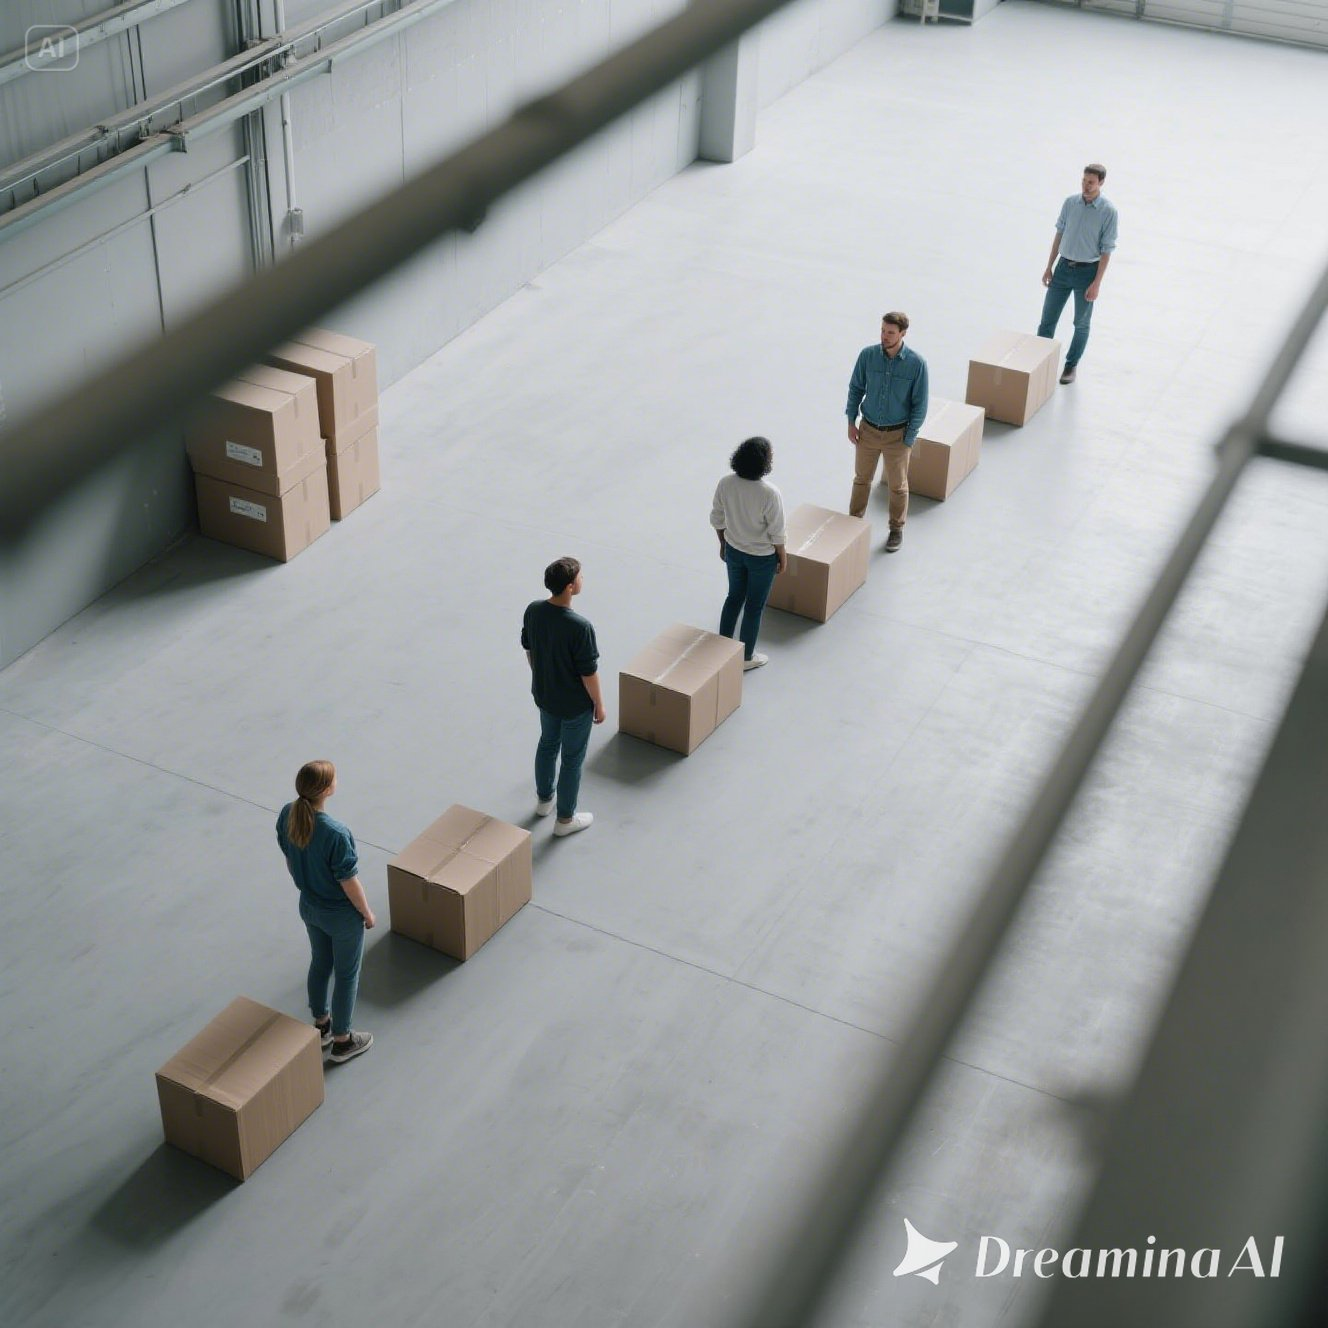


0: 640x640 10 boxs, 5 humans, 196.1ms
Speed: 13.5ms preprocess, 196.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


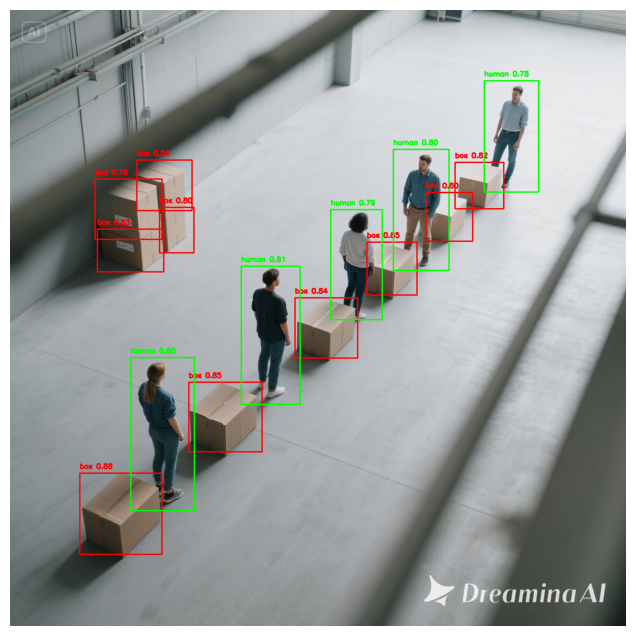


=== ผลลัพธ์การตรวจจับ ===
พบ box: 10 ชิ้น
พบ human: 5 ชิ้น
พบวัตถุทั้งหมด: 15 ชิ้น


In [8]:
from google.colab import files
import cv2
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt
from IPython.display import display, Image
import io

# โหลดโมเดล YOLO เวอร์ชันล่าสุดที่เทรนมาใหม่
model = YOLO("/content/drive/MyDrive/model/yolo400dataset/model/human_box_detection_20250607_230647/weights/best.pt")  # เปลี่ยนพาธตามโมเดลที่เทรนใหม่

def detect_objects(uploaded_file):
    # อ่านภาพจากไฟล์ที่อัพโหลด
    image_bytes = uploaded_file.read()
    image_np = np.frombuffer(image_bytes, np.uint8)
    img = cv2.imdecode(image_np, cv2.IMREAD_COLOR)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # ทำนายด้วยโมเดล
    results = model(img)

    # วาดผลลัพธ์บนภาพ
    for result in results:
        # วาด bounding boxes และ labels
        for box in result.boxes:
            x_min, y_min, x_max, y_max = map(int, box.xyxy[0].tolist())
            confidence = float(box.conf[0])
            class_id = int(box.cls[0])
            class_name = model.names[class_id]  # ใช้ชื่อคลาสจากโมเดลที่เทรนมา

            # สีสำหรับแต่ละคลาส
            if class_name == 'human':
                color = (0, 255, 0)  # เขียวสำหรับ human
            elif class_name == 'box':
                color = (255, 0, 0)  # น้ำเงินสำหรับ box
            else:
                color = (0, 0, 255)  # แดงสำหรับคลาสอื่นๆ

            # วาดกล่อง
            cv2.rectangle(img_rgb, (x_min, y_min), (x_max, y_max), color, 2)

            # แสดง label และ confidence
            label = f"{class_name} {confidence:.2f}"
            cv2.putText(img_rgb, label, (x_min, y_min - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # แสดงภาพผลลัพธ์
    plt.figure(figsize=(10, 8))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

    # นับจำนวนวัตถุที่พบแยกตามคลาส
    class_counts = {}
    for result in results:
        for box in result.boxes:
            class_id = int(box.cls[0])
            class_name = model.names[class_id]
            class_counts[class_name] = class_counts.get(class_name, 0) + 1

    # แสดงผลลัพธ์
    print("\n=== ผลลัพธ์การตรวจจับ ===")
    for class_name, count in class_counts.items():
        print(f"พบ {class_name}: {count} ชิ้น")
    print(f"พบวัตถุทั้งหมด: {sum(class_counts.values())} ชิ้น")

# ส่วนติดต่อผู้ใช้
def upload_and_detect():
    # สร้างปุ่มอัพโหลด
    upload_button = files.upload()

    # ประมวลผลเมื่ออัพโหลดไฟล์
    for filename in upload_button.keys():
        print(f"\nกำลังประมวลผลไฟล์: {filename}")

        # แสดงภาพต้นฉบับ
        print("\nภาพต้นฉบับ:")
        display(Image(filename, width=600))

        # ตรวจจับวัตถุ
        detect_objects(io.BytesIO(upload_button[filename]))

# คำแนะนำการใช้งาน
print("""
=== คำแนะนำการใช้งาน ===
1. กดปุ่ม "Choose Files" เพื่ออัพโหลดภาพ
2. รอสักครู่ให้ระบบประมวลผล
3. ดูผลลัพธ์การตรวจจับวัตถุ
""")

# เริ่มโปรแกรม
upload_and_detect()